In [85]:
import pandas as pd
import requests

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import numpy as np

In [86]:
df = pd.read_csv('APIData2000-FB.csv')

In [87]:
df = df[df['Ruling_Slug']!= 'no-flip']
df = df[df['Ruling_Slug']!= 'full-flop'] 
df = df[df['Ruling_Slug']!= 'half-flip']
df = df[df['Ruling_Slug']!= 'barely-true']
df.Ruling_Slug.unique()

array(['false', 'mostly-true', 'pants-fire', 'half-true', 'true'],
      dtype=object)

In [88]:
df.loc[df['Ruling_Slug'] == 'half-true', 'Ruling_Slug'] = 'true'
df.loc[df['Ruling_Slug'] == 'mostly-true', 'Ruling_Slug'] = 'true'
df.loc[df['Ruling_Slug'] == 'mostly-false', 'Ruling_Slug'] = 'false'
df.loc[df['Ruling_Slug'] == 'pants-fire', 'Ruling_Slug'] = 'false'
#df.loc[df['Ruling_Slug'] == 'barely-true', 'Ruling_Slug'] = 'false'
df.Ruling_Slug.unique()

array(['false', 'true'], dtype=object)

In [89]:
df.loc[df['Ruling_Slug'] == 'true', 'Ruling_Slug'] = 1
df.loc[df['Ruling_Slug'] == 'false', 'Ruling_Slug'] = 0
df.Ruling_Slug.unique()

array([0, 1], dtype=object)

In [90]:
df.head()

,Unnamed: 0,Sequence,Ruling_Comments,Slug,Sources,Speaker,Speaker_Slug,Statement,Ruling_Slug
0,0,18873,"Texas schools will be open this fall, but pare...",some-covid-19-deaths-have-been-children,"NBC DFW, Cornyn on COVID-19: We Still Don't Kn...",John Cornyn,john-cornyn,Says no one under the age of 20 has died of th...,0
1,1,18870,Do the Kiwis have something exceptional to sho...,yes-science-led-new-zealand-currently-has-no-l...,"Facebook, post (archived here), July 7, 2020\n...",Facebook posts,facebook-posts,New Zealand let health experts rather than pol...,1
2,2,18863,At a campaign event in western North Carolina ...,nc-republican-wrongfully-says-masks-do-not-work,"Story by the Hendersonville Times-News, ""Fores...",Dan Forest,dan-forest,"Multiple studies all said for decades, masks d...",0
5,5,18858,The Republican seeking to unseat U.S. Rep. Mat...,no-pa-congressman-matt-cartwright-did-not-call...,"Bognet for Congress Press Release, ""Cartwright...",Jim Bognet,jim-bognet,U.S. Rep. Matt Cartwright proposes to defund t...,0
6,6,18857,The U.S. Centers for Disease Control and Preve...,batch-faulty-cdc-covid-19-tests-didnt-contain-...,"Facebook post, July 6, 2020\nABC 3340, EXCLUSI...",Facebook posts,facebook-posts,Federal officials confirmed that the CDC sent ...,0


In [91]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

stopwords = nltk.corpus.stopwords.words('english')
extendStopWords = ['Say','Says','said','people']
stopwords.extend(extendStopWords)

y = df["Ruling_Slug"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["Statement"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [92]:
X
y

array([0, 1, 0, ..., 0, 0, 0], dtype=object)

In [93]:
import gensim


In [94]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [95]:
len(w2v_model.wv.vocab)

5278

In [96]:
#see a sample vector for random word, lets say Corona 
w2v_model["corona"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-3.7455054e-03, -3.3690613e-03, -2.8942665e-03, -3.3342920e-03,
        3.1785676e-03, -4.8362482e-03, -2.0820664e-03,  1.9338574e-03,
        3.5202936e-03,  1.9849765e-03, -9.2420558e-04, -2.3010080e-03,
       -1.7082755e-03, -4.7181970e-03, -1.3836478e-03,  5.0861011e-03,
        3.6316342e-03, -3.5439513e-03, -3.8079862e-03, -3.5101399e-03,
        3.8728239e-03,  2.9859802e-04, -1.4006334e-03, -3.1415850e-03,
        2.7220938e-03,  3.8715180e-03,  2.5637681e-03, -1.3893947e-03,
       -3.8162656e-03,  2.9477777e-03,  1.1920367e-03, -1.1332294e-03,
       -2.2194062e-03,  1.0881560e-03,  3.7313353e-03, -3.3842996e-03,
       -1.2723269e-04, -6.7353787e-05,  5.4091990e-05, -3.5179213e-03,
        3.3254400e-03,  6.2183267e-04,  4.3111509e-03,  8.5871777e-04,
       -3.7047986e-03,  4.3315468e-03,  7.3861639e-04, -2.5641611e-03,
        3.3336743e-03,  2.9396135e-04, -3.2288269e-03,  4.1411966e-03,
       -3.3021716e-03, -4.1292077e-03, -1.6031403e-03, -2.2264796e-03,
      

In [97]:
w2v_model.wv.most_similar("corona")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('700', 0.3556317090988159),
 ('daughter', 0.3402072489261627),
 ('abandoned', 0.33026283979415894),
 ('post', 0.3246486783027649),
 ('osama', 0.31118714809417725),
 ('detain', 0.3065977692604065),
 ('folks', 0.3055826425552368),
 ('getting', 0.30231669545173645),
 ('deliberately', 0.3006289005279541),
 ('sarah', 0.2942197918891907)]

In [98]:
#Feeding US Presidents
w2v_model.wv.most_similar(positive=["trump","obama", "clinton"])
#First was Bush

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('people', 0.7443649768829346),
 ('said', 0.71966153383255),
 ('says', 0.7130957841873169),
 ('saying', 0.6994816660881042),
 ('president', 0.6883561611175537),
 ('would', 0.6704502105712891),
 ('000', 0.6306294202804565),
 ('day', 0.6270318031311035),
 ('years', 0.6088911890983582),
 ('time', 0.6026270389556885)]

In [99]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it yo lower case, explicitely setting that as False
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [100]:
#X

In [101]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break       

says -> 1
trump -> 2
said -> 3
people -> 4
shows -> 5
president -> 6
photo -> 7
donald -> 8
coronavirus -> 9
obama -> 10


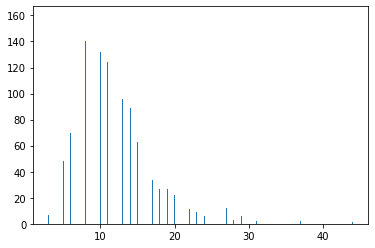

In [102]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 700 while tokenizing
from matplotlib import pyplot as plt
plt.hist([len(x) for x in X], bins=500)
plt.show()

In [103]:
nos = np.array([len(x) for x in X])

In [104]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 50])

1409

In [105]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 50 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [106]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [107]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [120]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [121]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [122]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           527900    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 645,277
Trainable params: 117,377
Non-trainable params: 527,900
_________________________________________________________________


In [111]:
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

In [112]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [113]:
from sklearn.linear_model import PassiveAggressiveClassifier
pa_classifier=PassiveAggressiveClassifier(C=0.5,max_iter=150)
pa_classifier.fit(X_train,y_train)

PassiveAggressiveClassifier(C=0.5, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=150, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)

In [114]:
y_pred=pa_classifier.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 74.22%


In [115]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
24/24 [==============================] - 2s 70ms/step - loss: 0.6088 - acc: 0.7497 - val_loss: 0.5190 - val_acc: 0.8107
Epoch 2/6
24/24 [==============================] - 1s 56ms/step - loss: 0.5561 - acc: 0.7578 - val_loss: 0.5350 - val_acc: 0.8107
Epoch 3/6
24/24 [==============================] - 1s 57ms/step - loss: 0.5670 - acc: 0.7578 - val_loss: 0.4861 - val_acc: 0.8107
Epoch 4/6
24/24 [==============================] - 1s 57ms/step - loss: 0.5567 - acc: 0.7578 - val_loss: 0.5076 - val_acc: 0.8107
Epoch 5/6
24/24 [==============================] - 1s 57ms/step - loss: 0.5546 - acc: 0.7578 - val_loss: 0.4851 - val_acc: 0.8107
Epoch 6/6
24/24 [==============================] - 1s 57ms/step - loss: 0.5612 - acc: 0.7578 - val_loss: 0.4933 - val_acc: 0.8107


In [116]:
#Prediction is in probability of news being real, so converting into classes
# Class 0 (Fake) if predicted prob < 0.5, else class 1 (Real)
y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [117]:
from sklearn.metrics import classification_report, accuracy_score
accuracy_score(y_test, y_pred)

0.7875354107648725

In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88       279
         1.0       0.00      0.00      0.00        74

    accuracy                           0.79       353
   macro avg       0.40      0.50      0.44       353
weighted avg       0.62      0.79      0.70       353



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [123]:
import gc
gc.collect()

193